## ANÁLISE DE COHORT ##


Já tem um tempo desde que vimos um projeto aplicado de Python, demonstrando como utilizar nossas skills para solucionar um problema de negócio. Já vimos isso para realizar a precificação de produtos e também na análise de Recência, Frequência e Valor. Hoje, vamos demonstrar como fazer uma análise de COHORT.

A análise de hoje é simples, mas muito útil, principalmente para quem trabalha com retenção de clientes. A ideia é mapear a entrada e saída da sua base, para entender a retenção ao longo do tempo. A tabela abaixo é o produto final de uma análise Cohort, feita em dias:

In [24]:
from IPython.display import Image

Image (url="https://lh6.googleusercontent.com/HmZLiwML0ie1GE4MZ1Q7FupxrRBzeSkUZ4dfH8aTz3SJXdKauAHiY3rYlUJioXZDW50ucAygSHg3Qr43rLeyKoscA7cfKCD2EWxc0KcKUh-LEZv5QMzWH0qXhotpFzCEIS5QpiVu0S134FTEu72J6Jo")

No exemplo acima, estamos falando do lançamento de um aplicativo, no qual 1.098 entraram no dia 25 de janeiro e, destes, 33.9% continuavam no dia seguinte; 23,5%, dois dias depois; 18,7% três dias depois e assim em diante. Fazemos isso diariamente, sempre registrando a entrada de clientes naquele dia e quantos permaneciam nos dias seguintes. Com isso, sabemos como anda a retenção de clientes. A depender do tipo de produto, a análise pode ser mais eficiente em meses.

### COMO CONSTRUIR UMA COHORT ###

Primeiro de tudo, você precisa ter uma tabela contendo algum tipo de recorrência de seus clientes. Por exemplo, quando fizemos nosso RFV, utilizamos um dataset de um e-commerce contendo as compras dos clientes. Aquele é um exemplo interessante para aplicar a análise que aprenderemos aqui. Para não repetir o dataset, vamos utilizar um dataset parecido, infelizmente vou apelar para um que já é um pouco manjado, mas pelo menos deixamos o do RFV para vocês validarem o entendimento obtido neste material. Você pode baixar o dataset deste material clicando

In [25]:
# Carregando Biblioteca
import pandas as pd

#Carregando Dataset
retail = pd.read_excel("Online Retail.xlsx")

#Exibe as primeiras linhas
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Temos no dataset, na ordem da primeira à última coluna: o código numérico que identifica a compra, o código numérico que identifica o item, a descrição do item em texto, a quantidade comprada, a data da compra, o preço unitário, a chave numérica de identificaçã

o do consumidor e o país da compra.

Se não conseguimos identificar o cliente, não vamos conseguir acompanhar seu comportamento ao longo do tempo. Por causa disso, vamos excluir linhas que não possuem a variável CustomerID preenchida.

In [26]:
retail.dropna( subset=['CustomerID'], inplace = True)

Não há muito o que a gente consiga fazer aqui, mas é interessante verificar como o dataset mudou de tamanho:

Perdemos uma quantidade razoável de linhas no dataset, cerca de 25%. Isso, no mundo real, é preocupante. Já vi projetos seguirem dessa forma, mas é o tipo de problemas de qualidade dos dados que deveria preocupar a equipe. Como aqui não temos muita ação sobre este problema, vamos apenas dar sequência.

Podemos realizar diversas análises dos dados, antes de começarmos efetivamente a gerar as cohorts. Geralmente, você verá as pessoas entendendo um pouco os dados, o que passa pela estatística descritiva das colunas:

In [27]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Veja que a quantidade média de itens por compras é em torno de 12, enquanto a mediana indica 5. Ou seja, temos uma distribuição bastante assimétrica.

Mais importante do que entender a visão geral, precisamos pegar as visões por consumidor. Afinal, se a demanda é de uma análise Cohort, é porque estamos entendendo nossos clientes. Sendo assim, como será que é a distribuição de compras feitas por nossos clientes? Quantas compras cada cliente fez?

Para responder à pergunta, basta contar quantos invoices cada cliente tem:

No contexto de vendas e análise de dados, "invoices" refere-se a faturas ou notas fiscais. Cada invoice é gerada quando uma compra é feita, representando um registro daquela transação.

No seu código e descrição, a ideia é verificar quantas faturas (ou transações) estão associadas a cada cliente para entender melhor o comportamento de compra. Contar os invoices por cliente ajuda a responder perguntas como:

Quantas compras um determinado cliente fez?
Qual o comportamento de compra recorrente dos clientes?
Assim, o número de invoices por cliente reflete quantas vezes esse cliente comprou na loja. É uma métrica útil para segmentar clientes e entender padrões de compras, especialmente em uma análise Cohort.

In [28]:
retail.groupby(["CustomerID"])["InvoiceNo"].nunique().sort_values()

CustomerID
15300.0      1
13833.0      1
16123.0      1
13829.0      1
13828.0      1
          ... 
13089.0    118
14606.0    128
17841.0    169
12748.0    224
14911.0    248
Name: InvoiceNo, Length: 4372, dtype: int64

Note que utilizamos nunique() e não size(). Isso foi feito porque queremos pegar quantos códigos de invoice, quantos números diferentes de invoice, cada cliente tem. Se utilizássemos size(), pegaríamos quantas linhas existem, e teríamos

um número bem maior porque o dataset possui repetições de invoices, cada compra pode ter mais de um item e isso faz com que tenhamos o mesmo número de invoice aparecendo diversas vezes.

In [29]:
invoice_per_costumer = retail.groupby(["CustomerID"])["InvoiceNo"].nunique()
invoice_per_costumer.describe()

count    4372.000000
mean        5.075480
std         9.338754
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: InvoiceNo, dtype: float64

Podemos ver que há muitos clientes com poucas compras e alguns poucos com muitas compras, claramente assimétrica a distribuição de invoices pelos consumidores. Podemos ver o comportamento pelo histograma também:

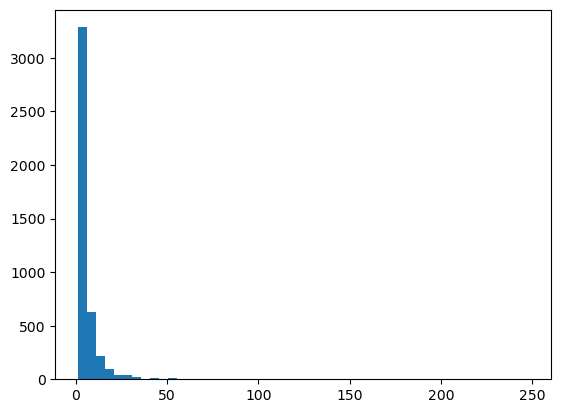

In [30]:
import matplotlib.pyplot as plt

_= plt.hist(invoice_per_costumer, bins=50)

É bem sutil, mas note que existem consumidores com 50, 100 e até 200 compras. Mas a maioria se encontra entre 0 e 5 compras.

Bom, agora podemos finalmente avançar para a cohort, já sabendo que podemos esperar pouca retenção. Lembra que a cohort é uma análise feita para verificar a retenção de clientes. No nosso caso, vamos identificar os clientes que seguem

realizando compras mensalmente. Sendo assim, o agrupamento será pela chave de identificação do cliente, a chave de identificação da compra e a data da compra:

In [31]:
# Primeira limpeza: Remover duplicidades

retail = retail[["CustomerID","InvoiceNo","InvoiceDate"]].drop_duplicates()

Tendo feito essa limpeza inicial, vamos começar a organizar nossas cohorts. Como faremos cohorts mensais, precisaremos identificar os meses em que o cliente fez compras. Sendo assim, vamos criar um campo para o mês da compra:



In [32]:
# Vamos organizar por meses
retail ["InvoiceMoth"] = retail["InvoiceDate"].dt.to_period("M")

Além disso, precisamos das datas das cohorts. A cohort de cada cliente se inicia no mês em que ele entrou na base da empresa como um consumidor, ou seja, na primeira compra:

In [33]:
retail["Cohort"] = retail.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M")

Utilizamos o transform() para criar a menor data de compra para cada cliente sem perder a estrutura original dos dados. Se não tivéssemos incluído o transform(), os dados ficariam agrupados como na visão do groupby. Depois de pegar a menor data, precisamos pegar o ano e mês dela, pois essa é a cohort. Caso contrário, não conseguiríamos colocar numa mesma cohort todos os clientes, cada um ficaria num dia diferente. Para visualizar melhor o que foi feito, podemos rodar retail.head() e exibir as primeiras linhas do dataset:

Note que o consumidor com a chave 17850.0 entrou na cohort de dezembro/2010, mas teve duas compras em 01/12/2010. Essas duas compras não nos importam muito, nós precisamos apenas saber que ele estava nessa cohort e identificar em quais outros momentos ele aparece.

O que a gente precisa fazer, no fim das contas, é contar quantos consumidores aparecem no início de cada cohort e quantos deles estão nos meses seguintes. Façamos o seguinte então: vamos agrupar por cohort e por mes de Invoice:

In [34]:
retail_cohort = retail.groupby(["Cohort","InvoiceMoth"]).agg(n_customers = ("CustomerID","nunique"))\
                .reset_index(drop = False)

retail_cohort.head()

,Cohort,InvoiceMoth,n_customers
0,2010-12,2010-12,948
1,2010-12,2011-01,362
2,2010-12,2011-02,317
3,2010-12,2011-03,367
4,2010-12,2011-04,341


Repare que boa parte da análise já está resolvida, temos todas as cohorts e sabemos quantos clientes permaneceram nos meses seguintes a suas entradas. Para facilitar a construção da matriz, vamos criar uma coluna com a numeração de cada período após o início da cohort. Por exemplo, se a cohort se iniciou em dezembro de 2010, o mês de janeiro de 2011 será o número 1, enquanto fevereiro será o 2 e assim em diante:

In [35]:
retail_cohort["Period"] = (retail_cohort.InvoiceMoth - retail_cohort.Cohort).apply(lambda x: x.n)

retail_cohort.head()

,Cohort,InvoiceMoth,n_customers,Period
0,2010-12,2010-12,948,0
1,2010-12,2011-01,362,1
2,2010-12,2011-02,317,2
3,2010-12,2011-03,367,3
4,2010-12,2011-04,341,4


Se você é usuário de Excel já sacou qual a solução aqui: usar uma tabela dinâmica! Ou, do inglês, uma pivot_table:

In [36]:
cohort_pivot = retail_cohort.pivot_table ( index = "Cohort", columns = "Period", values = "n_customers")
cohort_pivot

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se você não entendeu o funcionamento da Pivot Table, dê uma olhada neste tutorial: https://www.vooo.pro/insights/pivot-table-em-pandas-explicado/

Agora, estamos perto de finalizar, o que falta solucionar é: colocar os valores em percentual e criar um mapa de calor com os percentuais obtidos!

Pode ignorar o NaN por enquanto, vamos ver como pegar os percentuais que queremos. O que precisamos é simples, pegar os primeiros valores, localizados na primeira coluna e depois aplicá-los numa divisão como denominador da respectiva coluna. Para pegar os valores da primeira coluna, utilizaremos o iloc:

In [37]:
cohort_size = cohort_pivot.iloc[:,0]
cohort_size

Cohort
2010-12    948.0
2011-01    421.0
2011-02    380.0
2011-03    440.0
2011-04    299.0
2011-05    279.0
2011-06    235.0
2011-07    191.0
2011-08    167.0
2011-09    298.0
2011-10    352.0
2011-11    321.0
2011-12     41.0
Freq: M, Name: 0, dtype: float64

Primeiro passo feito com sucesso, sobrou fazer a divisão dos números das outras colunas pelo valor da primeira coluna de sua linha. Para isso, podemos aplicar o método divide do próprio Pandas e especificar que utilizaremos a divisão pelos valores da mesma linha, ou seja, incluímos o parâmetro axis=0:

In [38]:
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para fechar, vamos construir finalmente construir nosso mapa de calor final:

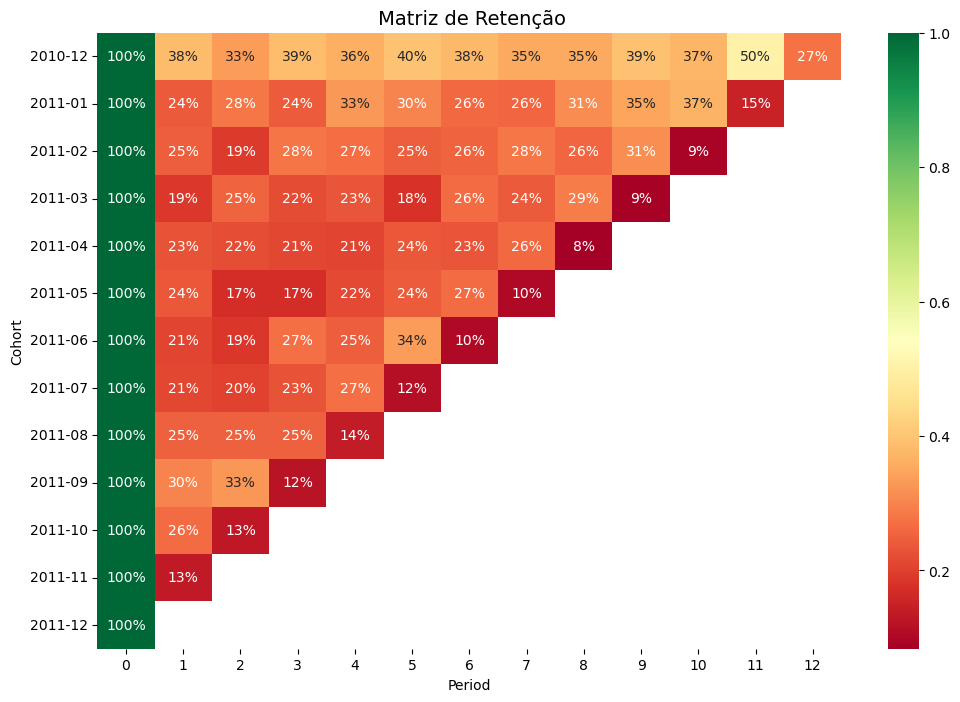

In [40]:

import seaborn as sns
import matplotlib.pyplot as plt


_= plt.subplots(figsize =(12, 8))

_ = sns.heatmap(
    data = retention_matrix,
    mask = retention_matrix.isnull(),
    annot = True,
    fmt = ".0%",
    cmap = "RdYlGn"
)

_= plt.title(" Matriz de Retenção", size = 14)

* **_ = plt.subplots(figsize=(12, 8))**: Cria uma figura com uma única plotagem (subplot) com tamanho de 12 por 8. O resultado é atribuído a uma variável não utilizada `_`, indicando que não estamos interessados no retorno específico dessa função. Em outras palavras, o underline colocado aqui e no restante do código vai evitar aqueles textos que costumam sair junto com o desenho do gráfico. Poderíamos utilizar ';' no fim da linha, mas eu me acostumei com este método porque o método de ponto-e-vírgula é retirado quando usamos %load_ext nb_black, que é um método que eu uso muito para ajustar a formatação do código.

* **_ = sns.heatmap(...):** Cria um heatmap utilizando o Seaborn, cujos parâmetros são:
 **data** = retention_matrix: Especifica os dados a serem plotados, neste caso, a matriz de retenção retention_matrix.
* **mask = retention_matrix.isnull():** Mascara os valores nulos na matriz, ou seja, oculta as células que possuem valores nulos.
* **annot = True:** Adiciona anotações (valores) nas células do heatmap.
* **fmt = '.0%':** Formata as anotações para exibirem como porcentagem sem casas decimais.
* **cmap = 'RdYlGn':** Define a paleta de cores utilizada no heatmap, neste caso, a paleta "RdYlGn", abreviação de RedYellowGreen (vermelho, amarelo, verde).
* **_ = plt.title('Matriz de Retenção', size=14):** Define o título do gráfico como "Matriz de Retenção" com tamanho de fonte de 14.

Agora, ficou fácil de você acompanhar como anda a entrada e saída de clientes. Normalmente, os produtos possuem um certo padrão, então você vai acabar vendo valores parecidos para a saída de clientes. Se você identificar alguma anomalia, pode ser evidência de algum evento anormal acontecendo no período.

Quem quiser testar a análise Cohort com os dados que utilizamos no RFV: https://www.kaggle.com/datasets/carrie1/ecommerce-data

A análise RFV foi feita na semana 11, caso você tenha pulado o material. O código completo também se encontra no Kaggle: https://www.kaggle.com/code/andreyukio/rfv-analise-pt-br